# Overview
This notebook uses the BrainBERT model to analyze neural signals.

### BrainBERT Workflow:

1. **sEEG Data to Spectrograms**:
   - **sEEG**: Records electrical brain activity.
   - **STFT**: Converts raw sEEG into spectrograms, showing frequency over time.

2. **Embedding Generation**:
   - **Input**: Spectrograms are fed as images to BrainBERT.
   - **Output**: BrainBERT produces embeddings, which are later classified as seizure/not seizure.

# Import Libraries

We import the following libraries for file operations, model handling, configurations, and data processing:

- `os`, `sys`: File and system operations.
- `models`: Custom ML models.
- `OmegaConf`: Configuration management.
- `numpy`: Numerical operations.
- `matplotlib.pyplot`: Plotting.
- `scipy`: Scientific computing.
- `torch`: Neural networks.

In [1]:
import os

# Set the working directory to BrainBERT
os.chdir('/home/vineetreddy/Dropbox/CZW_MIT/BrainBERT')

# Add the parent directory to the system path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch
from omegaconf import OmegaConf
import models

### Function: `plot_time_series(path)`

This function visualizes neural signal voltages over time by plotting a time series of the waveform data.

**Key Features:**
- **X-axis:** Labeled as "Time (s)" and represents time in seconds, with ticks converted from data points to time intervals at every 2048 data points.
- **Y-axis:** Labeled as "Voltage (µV)" to represent the signal amplitude in microvolts.
- **Plot Dimensions:** The plot is set to a width of 10 inches and a height of 3 inches.

**Note:** The `path` parameter is currently not utilized but is likely intended for loading the waveform data (`wav`).


In [2]:
def plot_time_series(path):
    """
    Plots a time series of the waveform data, useful for visualizing neural signal voltages over time.

    Parameters:
    - path (str): Path to the data file.

    The plot includes:
    - Y-axis labeled in microvolts (µV).
    - X-axis labeled in seconds, with ticks corresponding to every 2048 data points.
    """
    plt.figure(figsize=(10,3)) # Define plot size (width x height)
    plt.xticks(fontsize=20) # Set x-axis tick font size
    plt.yticks(fontsize=20) # Set y-axis tick font size
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25) # Y-axis label for voltage in microvolts
    
    # Convert x-axis ticks from data points to time (in seconds), with intervals every 2048 points
    plt.xticks(np.arange(0,len(wav)+1, 2048), [x/2048 for x in np.arange(0,len(wav)+1, 2048)]) 
   
    plt.xlabel("Time (s)", fontsize=25) # X-axis label for time in seconds
    plt.plot(wav) # Plot the waveform data

# Load and Plot Waveform Data

Load waveform data from `example_wav_1.npy` and plot it using `plot_time_series`.

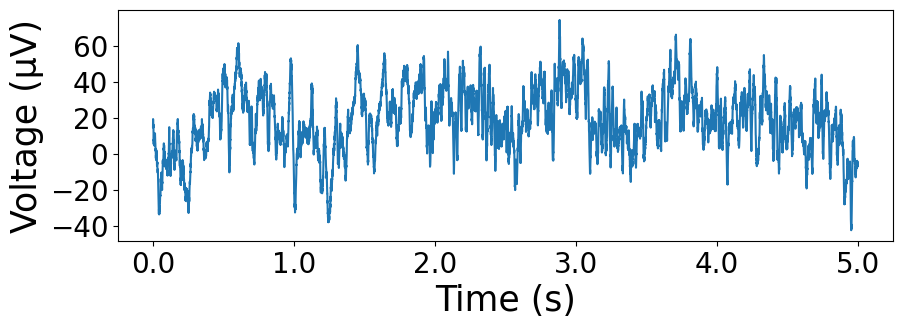

In [4]:
wav = np.load("/home/vineetreddy/Dropbox/CZW_MIT/example_wav_1.npy") # Load the waveform data
plot_time_series(wav) # Plot the waveform

### Function to Compute Short-Time Fourier Transform (STFT)

The STFT analyzes how the frequency content of a signal changes over time.

- `signal.stft`: Computes the STFT.
- `np.abs`: Returns the magnitude of the frequencies.
- `stats.zscore`: Applies z-score normalization for comparison across signals.
- Handles various normalizations and returns frequency, time, and transformed data.

Boundary effects are managed by clipping the edges of the data.

In [5]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    """
    Computes the Short-Time Fourier Transform (STFT) of a signal and applies optional normalization.

    Parameters:
    x : array_like
        Input signal.
    fs : float
        Sampling frequency of the input signal.
    clip_fs : int, optional
        Number of frequency components to retain after STFT. Default is -1, which keeps all components.
    normalizing : str, optional
        Type of normalization to apply to the STFT result. Options are:
        - 'zscore': Z-score normalization.
        - 'baselined': Baseline normalization.
        - 'db': Logarithmic (dB) normalization.
    **kwargs : dict
        Additional arguments to pass to the `signal.stft` function.

    Returns:
    f : ndarray
        Array of sample frequencies.
    t : ndarray
        Array of segment times.
    Zxx : ndarray
        STFT of x.
    """
    # Compute the Short-Time Fourier Transform (STFT)
    f, t, Zxx = signal.stft(x, fs, **kwargs)
    
    # Clip the frequency components if clip_fs is specified
    Zxx = Zxx[:clip_fs] 
    f = f[:clip_fs]

    # Take the absolute value (magnitude) of the STFT result
    Zxx = np.abs(Zxx) 
    
    # To handle boundary effects, we will clip the first and last few time points
    clip = 5 
    
    # Apply normalization if specified
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1) # Z-score normalization
        t = t[clip:-clip]
    
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip]) # Baseline normalization
        t = t[clip:-clip]
    
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip]) # Convert to decibels (dB)
        t = t[clip:-clip]

    # Check for NaN values in the STFT result and trigger debugging if found
    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace() 

    # Return the frequency, time, and transformed data
    return f, t, Zxx


# Define a function to plot the STFT of the signal

This function plots the STFT, showing how the frequency content of the signal changes over time.

- `plt.pcolormesh`: This creates a color plot, where colors represent the magnitude of frequencies.
- `plt.colorbar`: This adds a color bar to the plot, which shows the scale of magnitudes.
- The plot has labels and custom font sizes for readability.

- note: **TODO hardcode sampling rate**

In [6]:
def plot_stft(path, clip_fs=40):
    """
    Plots the Short-Time Fourier Transform (STFT) of a waveform.

    Parameters:
    path (str): The file path to the waveform data in .npy format.
    clip_fs (int, optional): The sampling frequency to clip at, default is 40.

    Returns:
    None: Displays a pseudocolor plot of the STFT.
    """
    # Load the waveform data from the specified path
    wav = np.load(path) 

    # Compute the STFT of the waveform
    # wav: Input waveform
    # 2048: FFT size (hardcoded, can be parameterized)
    # clip_fs: Sampling frequency
    # nperseg: Number of points per segment
    # noverlap: Number of points to overlap between segments
    # normalizing: Method to normalize the data
    # return_onesided: Return a one-sided spectrum
    f,t,linear = get_stft(wav, 2048, clip_fs=clip_fs, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True)
    
    # Set the size of the figure
    plt.figure(figsize=(15,3)) 

    # Create a pseudocolor plot of the STFT
    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5) 

    # Add a colorbar to the plot
    cbar = plt.colorbar(g1) # Add a colorbar
    
    # Set the font size of the colorbar ticks
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size) 
    
    # Set the label for the colorbar
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    
    # Set the font size of the x-ticks and y-ticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Label the x axis & y axis
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

# Call the function to plot the STFT of the example waveform data

Here we call the `plot_stft` function to create a plot showing how the frequencies in the example waveform data change over time.

- `clip_fs=25`: This limits the number of frequency components to show.


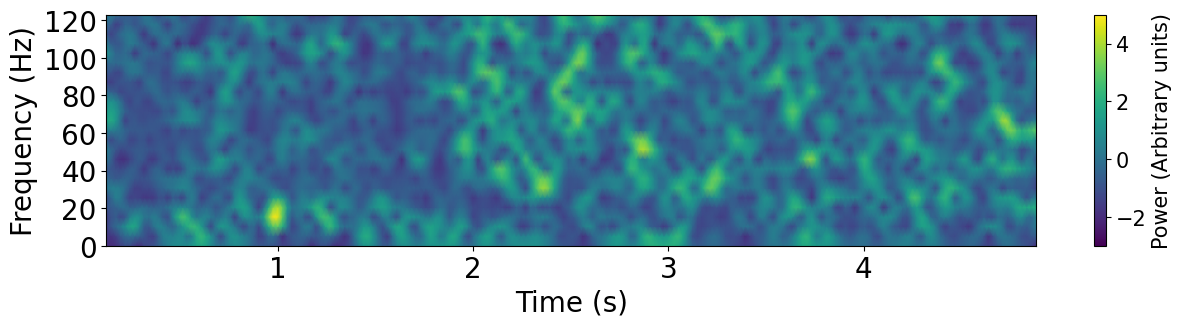

In [8]:
plot_stft("/home/vineetreddy/Dropbox/CZW_MIT/example_wav_1.npy", clip_fs=25)

# Define a function to build a model

In machine learning, we use models to learn from data and make predictions. This function builds a model using a configuration file that specifies the details of the model.

- `torch.load`: This loads a saved model from a file.
- `models.build_model`: This is a custom function that creates a model using the configuration.

In [9]:
def build_model(cfg):
    """
    Build and return a model using the configuration from a specified checkpoint.

    Parameters:
    cfg (object): Configuration object containing the path to the model checkpoint.

    Returns:
    nn.Module: The built model based on the configuration from the checkpoint.
    """
    # Path to the model checkpoint
    ckpt_path = cfg.upstream_ckpt 

    # Load the model checkpoint from the specified path
    init_state = torch.load(ckpt_path) 

    # Extract the model configuration from the loaded checkpoint
    upstream_cfg = init_state["model_cfg"] 

    # Build the model using the extracted configuration
    upstream = models.build_model(upstream_cfg) 

    # Return the built model
    return upstream 

# Define a function to load model weights

Models need to be trained on data to learn. This function loads the learned weights (parameters) into the model.

- `model.load_weights`: This is a custom function to load the weights into the model.
- `multi_gpu`: If using multiple GPUs (powerful processors for training models), load the weights accordingly.


In [10]:
def load_model_weights(model, states, multi_gpu):
    """
    Load weights into the model, accounting for single-GPU or multi-GPU setup.

    Parameters:
    model (nn.Module): The model into which the weights will be loaded.
    states (dict): The state dictionary containing the model weights.
    multi_gpu (bool): Flag indicating whether the model is in a multi-GPU setup.

    Returns:
    None
    """
    
    if multi_gpu:
        # Load weights for a model in a multi-GPU setup
        model.module.load_weights(states) 
    else:
        # Load weights for a model in a single-GPU setup
        model.load_weights(states)

# Specify the path to the model checkpoint and create a configuration object with the checkpoint path

We need to specify where the pre-trained model weights are stored and create a configuration object that holds this information.

- `OmegaConf.create`: This creates a configuration object.

In [13]:
# Path to the pre-trained weights for the model
ckpt_path = "/home/vineetreddy/Dropbox/CZW_MIT/stft_large_pretrained_256hz.pth" 

# Create a configuration object with the checkpoint path
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})

# Build and initialize the model

Now we build the model using the configuration and move it to the GPU for faster computations.

- `model.to('cuda')`: Moves the model to the GPU.
- `load_model_weights`: Loads the pre-trained weights into the model.

In [14]:
# Build the model using the provided configuration
model = build_model(cfg)

# Move the model to the GPU
model.to('cuda') 

# Load the initial state of the model from the checkpoint path
init_state = torch.load(ckpt_path)

# Load the model weights
load_model_weights(model, init_state['model'], False)

/home/vineetreddy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Compute the STFT of the waveform data and prepare the inputs for the model

We need to transform the waveform data into a format suitable for the model. This involves computing the STFT and converting the data to a tensor (a multi-dimensional array).

- `torch.FloatTensor`: Converts the data to a tensor.
- `unsqueeze(0)`: Adds an extra dimension to the tensor.
- `transpose(1, 2)`: Changes the order of dimensions in the tensor.
- `mask`: A mask used in the model to indicate which parts of the data to ignore.

In [15]:
# Compute STFT with specific parameters
f,t,linear = get_stft(wav, 2048, clip_fs=25, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True)

# Convert STFT to FloatTensor, add batch dim, transpose, and move to GPU
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')

# Create boolean mask on GPU with same shape as inputs (first two dims)
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda') 

# Get the model output without gradient computation and check the shapes of the inputs and the output

We pass the prepared data to the model to get the output.

- `torch.no_grad` ensures that we do not compute gradients, which saves memory and computation time during inference (prediction).
- `model.forward`: Runs the data through the model to get predictions.
- `inputs.shape, out.shape`: Checks the shapes of the input and output data to ensure they are correct.


In [16]:
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)
inputs.shape, out.shape

(torch.Size([1, 196, 25]), torch.Size([1, 196, 768]))